# Blahut-Arimoto algorithm to compute the channel capacity for a given input-output response.

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
# Our numerical workhorses
import numpy as np
import pandas as pd

import itertools
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Seaborn, useful for graphics
import seaborn as sns

# Pickle is useful for saving outputs that are computationally expensive
# to obtain every time
import pickle

import os
import glob

# Import the utils for this project
import chann_cap_utils as chann_cap

chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/blahut_algorithm_channel_capacity/'
tmpdir = '../../tmp/'

## Input probability that maximizes the information transmited through a channel $P(m \mid C)$

Given the symmetry in the mutual information, i.e. $I(m;C)=I(C;m)$ the problem of transmiting a message can be studied from two perspectives:
1. Given a **fix input** $P(C)$ what is the input-output response $P(m \mid C)$ that would minimize the information subject to some average distortion $D$.
2. Given a **fix channel** $P(m \mid C)$ what is the input distribution that would maximize the mutual information.

The first view is treated by rate-distortion theory. The second point is the problem of computing the so-called information capacity of a channel. This information capacity is defined as
\begin{equation}
    C \equiv \max_{P(C)} I(C;m),
\end{equation}
where the maximum is taken over the space of probabilities $P(C)$. This means that a probability distribution $P^*(C)$ achieves capacity if it maximizes the information that can be transmitted through a fix channel.

This second view brings interesting points for our theory. On the one hand we are trying to evolve/design a circuit which could respond given a distribution of inputs. For this case rate-distortion theory tells us the minimum amount of information the channel should transmit from the input to maintain an average growth rate. On the other hand we have the full theoretical input-output function response for a given set of parameters. In this case it would be interesting to find which distribution of inputs would maximize the mutual information, and what would that maximum mutual information value be.

Luckly for us in his elegant paper Blahut not only developed the rate-distortion algorithm we implemented previously, but he also showed a simple iterataive algorithm that can approximate the distribution of inputs that achieves capacity.

In this script we will implement such algorithm and compute the maximum mutual information one can transmit through a simple repression circuit!

## Testing the implementation of the algorithm.

Before going all in with the implementation of the algorithm is worth testing it with a simple example.

We will test the regular Blahut-Arimoto (BA) algorithm as well as the accelerated BA algorithm from Matz and Duhamel 2005.

Let's implement the BA first.

In [2]:
def channel_capacity(QmC, epsilon=1E-3, info=1E4):
    '''
    Performs the Blahut-Arimoto algorithm to compute the channel capacity
    given a channel QmC.

    Parameters
    ----------
    QmC : array-like 
        definition of the channel with C inputs and m outputs.
    epsilon : float.
        error tolerance for the algorithm to stop the iterations. The smaller
        epsilon is the more precise the rate-distortion function is, but also
        the larger the number of iterations the algorithm must perform
    info : int.
        Number indicating every how many cycles to print the cycle number as
        a visual output of the algorithm.
    Returns
    -------
    C : float.
        channel capacity, or the maximum information it can be transmitted 
        given the input-output function.
    pc : array-like.
        array containing the discrete probability distribution for the input 
        that maximizes the channel capacity
    '''
    # initialize the probability for the input.
    pC = np.repeat(1 / QmC.shape[0], QmC.shape[0])
        
    # Initialize variable that will serve as termination criteria
    Iu_Il = 1
    
    loop_count = 0
    # Perform a while loop until the stopping criteria is reached
    while Iu_Il > epsilon:
        if (loop_count % info == 0) & (loop_count != 0):
            print('loop : {0:d}, Iu - Il : {1:f}'.format(loop_count, Iu_Il))
        loop_count += 1
        # compute the relevant quantities. check the notes on the algorithm
        # for the interpretation of these quantities
        # cC = exp(∑_m Qm|C log(Qm|C / ∑_c pC Qm|C))
        sum_C_pC_QmC = np.sum((pC * QmC.T).T, axis=0)
        QmC_log_QmC_sum_C_pC_QmC = QmC * np.log(QmC / sum_C_pC_QmC)
        # check for values that go to -inf because of 0xlog0
        QmC_log_QmC_sum_C_pC_QmC[np.isnan(QmC_log_QmC_sum_C_pC_QmC)] = 0
        QmC_log_QmC_sum_C_pC_QmC[np.isneginf(QmC_log_QmC_sum_C_pC_QmC)] = 0
        cC = np.exp(np.sum(QmC_log_QmC_sum_C_pC_QmC, axis=1))
       
        # I_L log(∑_C pC cC)
        Il = np.log(np.sum(pC * cC))
        
        # I_U = log(max_C cC)
        Iu = np.log(cC.max())
        
        # pC = pC * cC / ∑_C pC * cC
        pC = pC * cC / np.sum(pC * cC)
        
        Iu_Il = Iu - Il
        
    # convert from nats to bits
    Il = Il / np.log(2)
    return Il, pC, loop_count

Let's test the algorithm with the exercise that Matz proposes in his paper.

In [3]:
QmC = np.array([[0.7, 0.1], [0.2, 0.2], [0.1, 0.7]])

Il, pC, loop_count = channel_capacity(QmC.T, 1E-10)

print('Regular BA algorithm')
print('Mutual info:', Il)
print('Input distribution:', pC)
print('Iterations:', loop_count)

Regular BA algorithm
Mutual info: 0.36514844544
Input distribution: [ 0.5  0.5]
Iterations: 1


Now the channel that Arimoto proposes in his paper

In [4]:
QmC = np.array([[0.6, 0.7, 0.5], [0.3, 0.1, 0.05], [0.1, 0.2, 0.45]])

Il, pC, loop_count = channel_capacity(QmC.T, 1E-10)

print('Regular BA algorithm')
print('Mutual info:', Il)
print('Input distribution:', pC)
print('Iterations:', loop_count)

Regular BA algorithm
Mutual info: 0.161631860824
Input distribution: [  5.01735450e-01   1.41574430e-09   4.98264548e-01]
Iterations: 305


The algorithm converges to the value reported on the paper. So we know that this implementation is working.


## Computing theoretical channel capacity for a simple repression regulatory circuit.

Given that the steady state mRNA and protein distributions $P(m, p \mid C)$ were computed using the maximum entropy approximation we can take the Lagrange multipliers associated with each inducer concentration $C$ and build the input output matrix $\mathbf{Q}_{g|c}$.

Let's read the data frame containing all these Lagrange multipliers.

In [5]:
df_maxEnt = pd.read_csv('../../data/csv_maxEnt_dist/' +
                        'MaxEnt_ss_Lagrange_multipliers.csv', index_col=0)
df_maxEnt.head()

,operator,binding_energy,repressor,inducer_uM,lambda_m1p0,lambda_m2p0,lambda_m3p0,lambda_m0p1,lambda_m0p2,lambda_m0p3,lambda_m1p1,lambda_m2p1,lambda_m1p2
0,O1,-15.3,1.0,0.0,-0.235712,-0.002642,0.000064,0.002107,-1.322508e-07,1.894975e-12,0.000027,-3.079414e-07,-1.572371e-10
1,O1,-15.3,1.0,0.1,-0.235105,-0.002664,0.000064,0.002108,-1.320565e-07,1.888360e-12,0.000027,-3.074050e-07,-1.563234e-10
2,O1,-15.3,1.0,1.0,-0.225664,-0.003018,0.000067,0.002120,-1.291254e-07,1.788371e-12,0.000027,-2.993814e-07,-1.424449e-10
3,O1,-15.3,1.0,5.0,-0.152349,-0.005945,0.000099,0.002289,-1.126244e-07,1.195997e-12,0.000024,-2.588073e-07,-5.289073e-11
4,O1,-15.3,1.0,7.5,-0.115523,-0.007674,0.000119,0.002482,-1.115887e-07,1.062469e-12,0.000023,-2.493538e-07,-2.627945e-11


Let's now define a function that takes a data frame for a particular repressor copy number and operator with all inducer concentrations, and computes each corresponding distribution $P(m, p \mid C)$ to then marginalize to obtain either $P(m \mid C) = \sum_p P(m, p \mid C)$, or $P(p \mid C) = \sum_m P(m, p \mid C)$.
Then it stacks all these marginal distributions to build the input-output matrix $\mathbf{Q}_{g|c}$.

In [6]:
def trans_matrix(df_lagrange, mRNA_space, protein_space, m_dist=True):
    '''
    Function that builds the transition matrix Qg|c for a series of
    concentrations c. It builds the matrix by using the tidy data-frames
    containing the list of Lagrange multipliers.
    
    Parameters
    ----------
    df_lagrange : pandas DataFrame.
        Data Frame containing the lagrange multipliers for a single straing,
        i.e. single operator and repressor copy number value.
    mRNA_space, protein_space : array-like.
        Array containing the sample space for the mRNA and the protein
        respectively
    m_dist : Bool. Default = True.
        Boolean indicating if the mRNA input-output matrix should be returned.
        If false the protein matrix is returned.
    
    Returns
    -------
    Qg|c : input output matrix in which each row represents a concentration
    and each column represents the probability of mRNA or protein copy number.
    '''
    # Extract unique concentrations
    c_array = df_lagrange['inducer_uM'].unique()
    
    # Extract the list of Lagrange multipliers
    lagrange_mult = [col for col in df_lagrange.columns if 'lambda' in col]
    # Extract the exponents corresponding to each Lagrange multiplier
    exponents = []
    for s in lagrange_mult:
        exponents.append([int(n) for n in list(s) if n.isdigit()])
    
    # Initialize input-output matrix
    if m_dist:
        Qgc = np.zeros([len(mRNA_space), len(c_array)])
    else:
        Qgc = np.zeros([len(protein_space), len(c_array)])
    
    # Group data frame by inducer concentration
    df_group = df_lagrange.groupby('inducer_uM')
    
    # Loop through each of the concentrations computing the distribution
    for i, (group, data) in enumerate(df_group):
        # Extract the Lagrange multiplier columns
        lagrange = data.loc[:, lagrange_mult].values[0]
        
        # Compute the distribution
        Pmp = chann_cap.maxEnt_from_lagrange(mRNA_space, protein_space, 
                                             lagrange,
                                             exponents=exponents)
        
        # Marginalize and add marignal distribution to Qg|c
        if m_dist:
            Qgc[:, i] = Pmp.sum(axis=0)
        else:
            Qgc[:, i] = Pmp.sum(axis=1)
            
    return Qgc

Having defined the function let's test it.

In [8]:
# Extract sample data frame
df_lagrange = df_maxEnt[(df_maxEnt.operator == 'O1') &
                        (df_maxEnt.repressor == 4)]

# Define sample space
mRNA_space = np.arange(0, 50)
protein_space = np.arange(0, 3E4)

# Build input-output matrix Qg|c
QgC = trans_matrix(df_lagrange, mRNA_space, protein_space, False)

Il, pC, loop_count = channel_capacity(QgC.T, 1E-3)

print('channel capacity: {:.2f} bits'.format(Il))

channel capacity: 1.11 bits


Having defined this function let's compute the channel capacity all the unique repressor-operator combinations in `df_maxEnt`.

In [19]:
# Group df_maxEnt by operator and repressor copy number
df_group = df_maxEnt.groupby(['operator', 'repressor'])

# Define column names for data frame
names = ['operator', 'binding_enery', 'repressor', 
         'channcap_mRNA', 'channcap_protein']

# Initialize data frame to save channel capacity computations
df_channcap = pd.DataFrame(columns=names)

compute_channcap = False
if compute_channcap:
    # Initialize dataFrame to save channel capacity computation
    df_channcap_mRNA = pd.DataFrame(columns=names)
    
    # Define function to compute in parallel the channel capacity
    def cc_parallel(df_lagrange):
        # Build mRNA transition matrix
        Qmc = trans_matrix(df_lagrange, mRNA_space, protein_space, True)

        # Build mRNA transition matrix
        Qpc = trans_matrix(df_lagrange, mRNA_space, protein_space, False)

        # Compute the channel capacity with the Blahut-Arimoto algorithm
        cc_m, _, _ = channel_capacity(Qmc.T, epsilon=1E-3)
        cc_p, _, _ = channel_capacity(Qpc.T, epsilon=1E-3)
        
        # Extract operator and repressor copy number
        op = df_lagrange.operator.unique()[0]
        eRA = df_lagrange.binding_energy.unique()[0]
        rep = df_lagrange.repressor.unique()[0]
        
        return [op, eRA, rep, cc_m, cc_p]
    # Run the function in parallel
    ccaps = Parallel(n_jobs=48)(delayed(cc_parallel)(df_lagrange)
                                for group, df_lagrange in df_group)
    
    # Convert to tidy data frame
    ccaps = pd.DataFrame(ccaps, columns=names)

    # Concatenate to data frame
    df_channcap = pd.concat([df_channcap, ccaps], axis=0)
    
    # Save results
    df_channcap.to_csv('../../data/csv_maxEnt_dist/MaxEnt_chann_cap.csv',
                       index=False)

Having computed the channel capacity let's look at the plot!

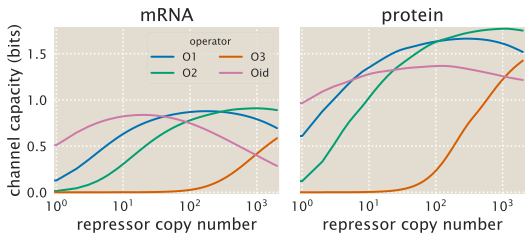

In [9]:
# Load data
df_channcap = pd.read_csv('../../data/csv_maxEnt_dist/MaxEnt_chann_cap.csv')

# Group data by operator
df_group = df_channcap.groupby('operator')

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5), sharey=True, sharex=True)

# Loop through each of the operators
for group, data in df_group:
    # Plot mRNA channel capacity
    ax[0].plot(data.repressor, data.channcap_mRNA, label=group)
    
    # Plot protein channel capacity
    ax[1].plot(data.repressor, data.channcap_protein, label=group)

# Label plot
ax[0].set_xlabel('repressor copy number')
ax[1].set_xlabel('repressor copy number')
ax[0].set_ylabel('channel capacity (bits)')

# Set title
ax[0].set_title('mRNA')
ax[1].set_title('protein')


ax[0].margins(0.01)
ax[0].set_xscale('log')
ax[0].legend(loc=0, title='operator', ncol=2)

plt.tight_layout()
plt.savefig(figdir + 'channel_capacity_mRNA_protein_vs_rep.pdf', 
            bbox_inches='tight')

### Compare with experimental data. 

Let's compare these predictions with experimental mircorscopy data (protein level).

First let's read the experimental channel capacity estimations. For this we will filter only the data taken exclusively for this project (note that the complete data set includes data from the `mcw_induction` project).

In [10]:
# Define directory where data is stored
expdir = '../../data/csv_channcap_bootstrap/'

# Define directory where the bootstrap data was stored
bootsdir = '../channcap_exp/'

# List files of data taken exclusively for this experiment
bootsfiles = [x for x in os.listdir(bootsdir) 
              if ('channel_capacity_experiment' in x) &
              ('ipynb' not in x)]

# Extract dates for these experiments
project_dates = [x.split('_')[0] for x in bootsfiles]


# List files with the bootstrap sampling of the
files = glob.glob(expdir + '*channcap_bootstrap.csv')

# Extract dates from these files
file_dates = [file.split('/')[-1] for file in files]
file_dates = [file.split('_')[0] for file in file_dates]

# Filter for files taken exclusively for this experiment.
files = [file for i, file in enumerate(files) if file_dates[i] in project_dates]

files

['../../data/csv_channcap_bootstrap/20180411_O1_HG104_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20180327_O3_RBS1L_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20180424_O1_RBS1L_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20161203_O2_RBS1027_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20180418_O3_HG104_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20180326_O2_HG104_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20180403_O2_RBS1L_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20180329_O3_RBS1027_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20180412_O1_HG104_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20180417_O1_RBS1027_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20180402_O2_RBS1L_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20161207_O2_HG104_channcap_bootstrap.csv',
 '../../data/csv_channcap_bootstrap/20180416_O

Let's systematically read each of the files, extract the data from the bin number closest to **100** and compute the channel capacity estimate for this bin number.

But first let's define a couple of dictionaries to map from RBS name to repressor co py number and from operator yo binding energy.

In [11]:
# Define dictionaries to map operator to binding energy and rbs to rep copy 
op_dict = dict(zip(['O1', 'O2', 'O3', 'Oid'], [-15.3, -13.9, -9.7, -17]))
rbs_dict = dict(zip(['HG104', 'RBS1147', 'RBS446', 'RBS1027', 'RBS1', 'RBS1L'],
                    [22, 60, 124, 260, 1220, 1740]))

Now let's save the data in a tidy `DataFrame`.

In [12]:
# Define index of entries to save
index = ['date', 'bins', 'operator', 'rbs', 
         'binding energy', 'repressors', 'channcap']
# Initialize DataFrame to save information
df_cc_exp = pd.DataFrame(columns=index)

# Define bin number to extract
bin_target = 100

# Loop through files
for f in files:
    # Split file name to extract info
    str_split = f.replace(expdir, '').split('_')
    # Extract date, operator and rbs info
    date, op, rbs = str_split[0:3]
    # Map the binding energy and repressor copy number
    eRA, rep = op_dict[op], rbs_dict[rbs]
    
    # Read file
    df_cc_bs = pd.read_csv(f, header=0)

    # Select df_cc_bs closest to desired number of bins
    # Find the index of the min df_cc_bs
    bin_idx = (np.abs(df_cc_bs['bins'] - bin_target)).idxmin()
    # Choose the bind number
    bin_num = df_cc_bs.iloc[bin_idx]['bins']

    # Keep only df_cc_bs with this bin number
    df_cc_bs = df_cc_bs[df_cc_bs['bins'] == bin_num]

    # Extrapolate to N -> oo
    x = 1 / df_cc_bs.samp_size
    y = df_cc_bs.channcap_bs
    # Perform linear regression
    lin_reg = np.polyfit(x, y, deg=1)
    # Extract intercept to find channel capacity estimate
    cc = lin_reg[1]

    # Compile info into a pandas series to append it to the DataFrame
    series = pd.Series([date, bin_num, op, rbs, eRA, rep, cc],
                       index=index)
    # Append to DataFrame
    df_cc_exp = df_cc_exp.append(series, ignore_index=True)

df_cc_exp.head()

,date,bins,operator,rbs,binding energy,repressors,channcap
0,20180411,104.0,O1,HG104,-15.3,22,1.370013
1,20180327,104.0,O3,RBS1L,-9.7,1740,0.910818
2,20180424,104.0,O1,RBS1L,-15.3,1740,1.391317
3,20161203,104.0,O2,RBS1027,-13.9,260,1.652293
4,20180418,104.0,O3,HG104,-9.7,22,0.085772


Having extracted the data let's plot it on top of the predictions!

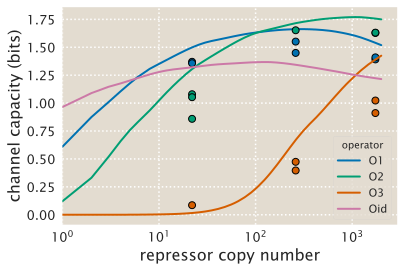

In [15]:
# Load data
df_channcap = pd.read_csv('../../data/csv_maxEnt_dist/MaxEnt_chann_cap.csv')

# Group data by operator
df_group = df_channcap.groupby('operator')

# Define colors for each operator
operators = df_channcap['operator'].unique()
colors = sns.color_palette('colorblind', n_colors=len(operators))
op_col_dict = dict(zip(operators, colors))

fig, ax = plt.subplots(1, 1)
for group, data in df_group:
    ax.plot(data.repressor, data.channcap_protein,
            label=group, color=op_col_dict[group])
    # Plot data from operator
    ax.plot(df_cc_exp[df_cc_exp['operator'] == group]['repressors'], 
            df_cc_exp[df_cc_exp['operator'] == group]['channcap'], 
            lw=0, marker='o', color=op_col_dict[group], label='',
            alpha=0.8, markeredgecolor='black', markeredgewidth=1)

# Label plot
ax.set_xlabel('repressor copy number')
ax.set_ylabel('channel capacity (bits)')
ax.set_xscale('log')
ax.set_xlim(left=1)
ax.legend(loc=0, title='operator')
plt.savefig(figdir + 'theory_vs_data_channcap_protein.pdf', bbox_inches='tight')

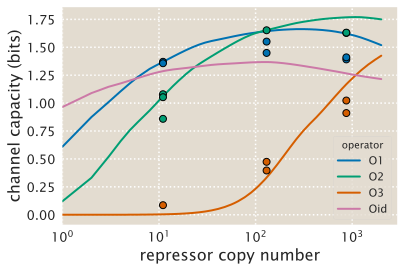

In [16]:
# Group data by operator
df_group = df_channcap.groupby('operator')

# Define colors for each operator
operators = df_channcap['operator'].unique()
colors = sns.color_palette('colorblind', n_colors=len(operators))
op_col_dict = dict(zip(operators, colors))

fig, ax = plt.subplots(1, 1)
for group, data in df_group:
    ax.plot(data.repressor, data.channcap_protein,
            label=group, color=op_col_dict[group])
    # Plot data from operator
    ax.plot(df_cc_exp[df_cc_exp['operator'] == group]['repressors'] / 2, 
            df_cc_exp[df_cc_exp['operator'] == group]['channcap'], 
            lw=0, marker='o', color=op_col_dict[group], label='',
            alpha=0.8, markeredgecolor='black', markeredgewidth=1)

# Label plot
ax.set_xlabel('repressor copy number')
ax.set_ylabel('channel capacity (bits)')
ax.set_xscale('log')
ax.legend(loc=0, title='operator')
ax.set_xlim(left=1)
plt.savefig(figdir + 'theory_vs_data_channcap_protein_div.pdf', 
            bbox_inches='tight')